<a href="https://colab.research.google.com/github/rsn870/Inversion_with_StyleGANXL/blob/main/Colorization_with_styleganXL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/autonomousvision/stylegan_xl.git

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 291 (delta 72), reused 48 (delta 41), pack-reused 192
Receiving objects: 100% (291/291), 6.57 MiB | 8.09 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [2]:
!pip install einops ninja
!pip install timm
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 6.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.3 MB/s 


In [3]:
cd stylegan_xl 

/content/stylegan_xl


Dnnlib works only inside styleganxl folder

In [4]:

import io
import os, time, glob
import pickle
import shutil
import sys
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'



Using device: cuda:0


In [5]:
Model = 'Imagenet-512' #@param ["Imagenet-1024", "Imagenet-512", "Imagenet-256", "Imagenet-128", "Pokemon", "FFHQ"]

#@markdown ---

network_url = {
    "Imagenet-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl",
    "Imagenet-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl",
    "Imagenet-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl",
    "Imagenet-128": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon1024.pkl",
    "Pokemon-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon512.pkl",
    "Pokemon-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

--2022-05-31 02:15:03--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.201
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1973325502 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet512.pkl’

imagenet512.pkl     100%[===================>]   1.84G  11.5MB/s    in 2m 51s  

2022-05-31 02:17:56 (11.0 MB/s) - ‘imagenet512.pkl’ saved [1973325502/1973325502]

Setting up PyTorch plugin "bias_act_plugin"... Done.


#Create Grayscale Versions for GT

In [6]:
import os 

imhr = sorted(os.listdir('/content/images_or'))

imhr = [imhr[it] for it in range(len(imhr))]

imhrlist = [Image.open(os.path.join('/content/images_or/',path)).resize((256,256)) for path in imhr]

imhrlist_2 = [im.convert('L') for im in imhrlist] 



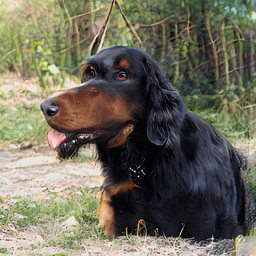

In [7]:
imhrlist[0]

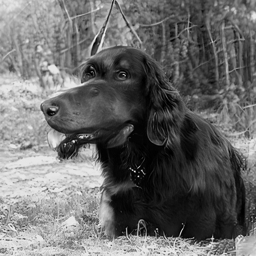

In [8]:
imhrlist_2[0]

In [10]:
for image in range(len(imhrlist)):
    

    imhrlist_2[image].save('/content/grayscale/'+imhr[image])


#Data Preprocessing

In [11]:
  def read_image(imagename,image_transforms):

        ims = sorted(os.listdir(imagename))
        image = [Image.open(os.path.join(imagename,path)) for path in ims]
        return [image_transforms(imag).unsqueeze(0) for imag in image]

In [12]:
imagename = '/content/grayscale'

In [13]:
from torchvision import transforms

In [14]:
image_transforms = transforms.Compose([
                                    
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])])

In [15]:
def tensor2numpy(images):
        """ we assume the shape of image is (1, C, H, W), and it's a cuda pytorch tensor
        """
        images = torch.clamp(images.detach(), min=-1, max=1)
        images = ((images+1)/2)*255
        images = images.permute(0,2,3,1).detach().cpu().numpy().astype('uint8')
        return images


In [16]:
cd ../

/content


#Set up Training Parameters

In [17]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-dyzkmliy
  Running command git clone -q https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-dyzkmliy
  Running command git submodule update --init --recursive -q
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4979 sha256=33a33186fca1eb2e3a0565097134ebcc60183fb2ca99faacdf7ac8a21bb22205
  Stored in directory: /tmp/pip-ephem-wheel-cache-t4a1w6_g/wheels/1e/cf/b5/31d11273e162675221f38043989d970cf7c7c8571d4e8d456d
Failed to build lpips-pytorch
    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip

In [18]:
from lpips_pytorch import LPIPS

In [19]:
lpips_criterion =  LPIPS(net_type='alex', version='0.1')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [20]:
from torch import nn

MSE_criterion = nn.MSELoss()

In [21]:
import os

In [22]:
exppath = '/content/results'

In [23]:
image = read_image(imagename, image_transforms)
        

In [24]:
learning_rate = 5e-2

In [25]:
from torchvision.transforms.functional import rgb_to_grayscale as colorizer

#Actual training using Colorization Loss 





In [28]:



for i in tqdm(range(len(image))):
            a = torch.randn([1, 512], device=device)*0.6 + w_all_classes_avg*0.4
            latentcode = ((a-w_all_classes_avg)/w_stds)
            latentcode.requires_grad = True
            optimizer = torch.optim.Adam([latentcode], lr=learning_rate)
            for step in tqdm(range(5000)):
                decoded_image = G.synthesis((latentcode* w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
                decoded_image_ds = F.interpolate(decoded_image, size=(256,256), mode='bicubic').cpu()
                decoded_image_ds = colorizer(decoded_image_ds)
                lpipsloss = lpips_criterion(decoded_image_ds, image[i].cpu())
                mseloss = MSE_criterion(decoded_image_ds, image[i].cpu())

                loss =lpipsloss + mseloss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                dataitems = {'lpipsloss': lpipsloss,
                         'mseloss': mseloss}
                if step % 50 == 0 or step == 1000:
                    decoded_image_np = tensor2numpy(decoded_image.clamp(-1,1))
                    decoded_image_np = Image.fromarray(decoded_image_np[0])
                    os.makedirs(f'{exppath}/images/{i+1}',exist_ok=True)
                    decoded_image_np.save(f'{exppath}/images/{i+1}/{step}.png')

            os.makedirs(f'{exppath}/latent/{i+1}',exist_ok=True)

            torch.save(latentcode.detach().cpu(),f'{exppath}/latent/{i+1}/latent_{i+1}.pt')
            


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored